In [ ]:
# If the code is not run on google colab, comment first line
from google.colab import files

# Data manipulation
from tabulate import tabulate
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import shap

# Other 
import time
import random

In [ ]:
#set display options
pd.set_option('display.max_colwidth', None)


# Upload / Clean Data

!!! IMPORTANT !!

The dataset was to big to upload on MarkUs.The dataset we used was here -> https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018)

Download the following tables -> (2014_Financial_Data.csv, 2015_Financial_Data.csv, 2016_Financial_Data.csv, 2017_Financial_Data.csv, 2018_Financial_Data.csv)

!!! IMPORTANT !!

In this section, we upload the data, visualize it, and do a bit of cleaning and understanding of the data. If the code is not run on Google Colab, you can skip the next block

In [ ]:
# Upload 2014-2018 Financial Data (Financial Indicators of US sotcks https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018)
# Upload the files provided in the zip file (2014_Financial_Data.csv, 2015_Financial_Data.csv, 2016_Financial_Data.csv, 2017_Financial_Data.csv, 2018_Financial_Data.csv)
uploaded = files.upload()

If the previous block was skipped, make sure the dataset files are in the same directory as the code.

In [ ]:
df_2014 = pd.read_csv("2014_Financial_Data.csv")
df_2015 = pd.read_csv("2015_Financial_Data.csv")
df_2016 = pd.read_csv("2016_Financial_Data.csv")
df_2017 = pd.read_csv("2017_Financial_Data.csv")
df_2018 = pd.read_csv("2018_Financial_Data.csv")

In [ ]:
random.seed(42)

In [ ]:
df_list = [df_2014,df_2015,df_2016,df_2017,df_2018]
year_list = ["2014", "2015", "2016", "2017", "2018"]

In [ ]:
df_2015.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2016 PRICE VAR [%],Class
0,PG,7.074900e+10,-0.0491,3.705600e+10,3.369300e+10,0.000000e+00,2.061600e+10,2.264400e+10,1.104900e+10,6.260000e+08,...,-0.2847,-0.2634,-0.1024,-0.1013,-0.1432,0.0000,-0.0394,Consumer Defensive,10.809451,1
1,VIPS,6.193685e+09,0.6587,4.669038e+09,1.524648e+09,1.658481e+08,5.223879e+08,1.205660e+09,3.189877e+08,1.321245e+07,...,28.6759,0.2144,0.1279,0.2946,0.0281,0.5309,0.5179,Consumer Defensive,-21.637010,0
2,KR,1.084650e+11,0.1026,8.551200e+10,2.295300e+10,0.000000e+00,1.716100e+10,1.981600e+10,3.137000e+09,4.880000e+08,...,0.1344,0.0065,0.0415,0.0535,0.0254,0.0000,0.1293,Consumer Defensive,-15.036503,0
3,RAD,2.652838e+10,0.0393,1.895164e+10,7.576732e+09,0.000000e+00,6.695642e+09,6.733788e+09,8.429440e+08,3.976120e+08,...,0.0336,-0.0371,0.2639,1.0266,-0.0344,0.0000,0.0205,Consumer Defensive,4.303799,1
4,GIS,1.763030e+10,-0.0156,1.168110e+10,5.949200e+09,0.000000e+00,3.328000e+09,3.871900e+09,2.077300e+09,3.154000e+08,...,-0.0653,-0.0119,-0.0568,-0.2118,0.0462,0.0000,-0.0421,Consumer Defensive,10.693172,1


In [ ]:
# Add Year of Data column and add name for ticker column:
for index, df in enumerate(df_list):
  df.columns.values[0] = "Ticker"
  df.columns.values[-2] = "1 Year Price Var [%]" 
  df.insert(0,"Year of Data", year_list[index])

In [ ]:
# Concatenate all tables to get 2014-2018 data together and shuffle rows 
df_14_18 = pd.concat(df_list, ignore_index=True)
df_14_18 = df_14_18.sample(frac=1,random_state=0)

In [ ]:
# find duplicate columns
def find_duplicate_columns(df):
  columns = df.select_dtypes(include=[np.number]).columns
  remove_columns = []
  for ref_column in columns:
    for check_column in columns:
      if ref_column == check_column or ref_column in remove_columns:
        continue
      # if df[check_column].equals(df[ref_column]):
      the_sum = sum(abs((df[check_column] - df[ref_column]).fillna(0)))
      if abs(the_sum) < 0.5: # allow for floating point errors
        print(f"{check_column} is a duplicate of {ref_column}")
        # print(the_sum)
        remove_columns.append(check_column)
  return remove_columns

# remove_columns = find_duplicate_columns(df_14_18)

In [ ]:
# To save time, we already ran the function above before
remove_columns = ['PB ratio',
 'PE ratio',
 'eBITperRevenue',
 'eBTperEBIT',
 'nIperEBT',
 'Return on Tangible Assets',
 'ROE',
 'ROIC',
 'Payables Turnover',
 'Inventory Turnover',
 'Current ratio',
 'Days of Inventory on Hand',
 'Days Sales Outstanding',
 'Days Payables Outstanding',
 'Debt to Assets',
 'Debt to Equity',
 'cashFlowCoverageRatios',
 'Operating Cash Flow per Share',
 'Free Cash Flow per Share',
 'Cash per Share',
 'Payout Ratio']
 
# Drop duplicate columns
df_14_18 = df_14_18.drop(columns=remove_columns)

In [ ]:
df_14_18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 16477 to 2732
Columns: 205 entries, Year of Data to Class
dtypes: float64(201), int64(1), object(3)
memory usage: 34.7+ MB


In [ ]:
# Get categorical and numerical features
categorical_features = df_14_18.select_dtypes(include=[np.object])
numerical_features = df_14_18.select_dtypes(include=[np.number])
print(categorical_features.columns)
print(numerical_features.columns)


Index(['Year of Data', 'Ticker', 'Sector'], dtype='object')
Index(['Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense', 'Earnings before Tax',
       ...
       '3Y Dividend per Share Growth (per Share)', 'Receivables growth',
       'Inventory Growth', 'Asset Growth', 'Book Value per Share Growth',
       'Debt Growth', 'R&D Expense Growth', 'SG&A Expenses Growth',
       '1 Year Price Var [%]', 'Class'],
      dtype='object', length=202)


`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
df_14_18.head()

,Year of Data,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,1 Year Price Var [%],Class
16477,2017,PYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Financial Services,-7.660304,0
14825,2017,JASN,6.486160e+08,-0.0807,517764000.0,1.308520e+08,0.0,103855000.0,1.073620e+08,2.349000e+07,...,-0.1183,-0.0378,-0.0643,2.6148,-0.0556,0.0000,-0.0874,Industrials,-43.621401,0
18794,2018,RMD,2.340196e+09,0.1323,978032000.0,1.362164e+09,155149000.0,600369000.0,8.203330e+08,5.418310e+08,...,0.0736,0.0014,-0.1166,0.0400,-0.7391,0.0739,0.0838,Healthcare,40.435954,1
18162,2018,CXO,4.151000e+09,0.6052,950000000.0,3.201000e+09,65000000.0,311000000.0,1.103000e+09,2.098000e+09,...,0.5304,1.5000,0.9148,0.5632,0.4115,0.1017,0.2746,Energy,-17.440006,0
12654,2016,COCP,0.000000e+00,-1.0000,0.0,0.000000e+00,101679000.0,4140000.0,1.058190e+08,-1.058190e+08,...,-0.3438,0.0000,-0.4431,-0.4545,0.0000,1.1514,-0.3880,Technology,-48.717948,0


In [ ]:
df_14_18.describe()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,1 Year Price Var [%],Class
count,2.090600e+04,19989.000000,2.030600e+04,2.087000e+04,1.993900e+04,2.040800e+04,2.037500e+04,2.097600e+04,2.035800e+04,2.071300e+04,...,18264.000000,19952.000000,19650.000000,19690.000000,19213.000000,19462.000000,19598.000000,19655.000000,2.207700e+04,22077.000000
mean,5.161619e+09,3.622214,3.258565e+09,1.970452e+09,1.033333e+08,8.699279e+08,1.368670e+09,5.896979e+08,9.778939e+07,4.925003e+08,...,0.012298,10.978239,0.158858,1.134221,0.783208,3.733922,0.295610,0.365149,2.698893e+02,0.550754
std,3.197314e+10,312.648170,2.583092e+10,8.735750e+09,7.676062e+08,3.804283e+09,5.662984e+09,2.976454e+09,4.996543e+08,2.484345e+09,...,0.263079,1101.098165,3.268154,45.381079,66.524006,174.864701,12.974127,15.030054,1.934617e+04,0.497429
min,-6.276160e+08,-12.769300,-2.986888e+09,-1.280800e+10,-1.098000e+08,-1.401594e+08,-5.495512e+09,-1.933900e+10,-1.710954e+09,-2.177200e+10,...,-1.000000,-1.000000,-1.000000,-1.000000,-3963.131200,-1.051000,-2.662200,-2.369900,-1.003972e+02,0.000000
25%,5.880737e+07,-0.014700,3.211750e+06,3.035575e+07,0.000000e+00,1.768550e+07,3.564150e+07,-4.433750e+06,0.000000e+00,-8.745000e+06,...,0.000000,-0.051125,0.000000,-0.031075,-0.103800,-0.067475,0.000000,-0.013700,-1.947409e+01,0.000000
50%,4.352510e+08,0.057600,1.530115e+08,1.943525e+08,0.000000e+00,8.062450e+07,1.564000e+08,3.585350e+07,3.697000e+06,2.380000e+07,...,0.000000,0.009500,0.000000,0.048000,0.032400,0.000000,0.000000,0.061000,3.909087e+00,1.000000
75%,2.287259e+09,0.182400,1.180224e+09,8.806035e+08,1.220150e+07,3.699722e+08,6.210870e+08,2.554363e+08,4.969325e+07,1.964680e+08,...,0.040000,0.200550,0.058400,0.176800,0.142100,0.150075,0.000000,0.185350,2.750567e+01,1.000000
max,1.886894e+12,42138.663900,1.581527e+12,4.621600e+11,2.883700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,8.720500e+10,...,5.400500,153332.333300,293.473000,5468.426400,7039.325900,17646.823500,1542.611000,2042.000000,2.418601e+06,1.000000


In [ ]:
df_14_18.isnull().sum().sort_values(ascending=False).head(10)

operatingCycle                                22058
cashConversionCycle                           22058
shortTermCoverageRatios                       10744
10Y Shareholders Equity Growth (per Share)     9680
10Y Revenue Growth (per Share)                 9532
10Y Net Income Growth (per Share)              9532
10Y Operating CF Growth (per Share)            9478
10Y Dividend per Share Growth (per Share)      9177
dividendPayoutRatio                            9079
priceEarningsToGrowthRatio                     9079
dtype: int64

From the results above, it can be seen that multiple features have a lot of missing data. There are different approaches for handling columns with many missing values. One approach is to remove any columns that has more than 70% missing data. This technique was suggested in this article:  https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/

In [ ]:
# This block removes features if the missing values represents more than 70% of the feature.

limit = len(df_14_18) * .3 # columns needs at least that number of non Na rows to stay
original_length = len(df_14_18)
df_14_18 = df_14_18.dropna(thresh=limit, axis=1)

print(f'The number of features went from {len((df).axes[1])-1} to {len(df_14_18.axes[1])-1} \n')

# Remove any rows if the target is null
df_14_18 = df_14_18.dropna(subset=['Class'])
new_length = len(df_14_18)
print(f"{original_length-new_length} rows were removed for missing target. The table now contains {new_length} rows")

The number of features went from 225 to 202 

0 rows were removed for missing target. The table now contains 22077 rows


# EDA

We performed Exploratory Data Analysis in this section. We started by dropping the outliers from the dataset, then we analyzed the data by using a dendogram. After, we verified the class distribution, the cardinality of data and the correlation between features. We also filled any missing values.

## Dropping Outliers

Dropping outliers for specific features that have same scale. The outliers were removed for the following features:
- EPS (Earning Per Shares)
- Dividen yield (%)
- EPS Diluted
- priceBookValueRatio
- priceToBookRatio
- priceToSalesRatio
- priceEarningsRatio
- priceToFreeCashFlowsRatio
- priceToOperatingCashFlowsRatio
- priceCashFlowRatio
- priceEarningsToGrowthRatio
- priceSalesRatio


In [ ]:
# This code returns any features that has the word ratio, dividend or margin in its name. 
Outlier_Features_List = [] # Contains list of all the features we can remove outliers

for column in df_14_18.columns:
  feature_name = column.lower()
  if ("ratio" in feature_name)|("dividend" in feature_name)|("margin" in feature_name):
    Outlier_Features_List.append(column)
 

In [ ]:
Outlier_Features_List

['Preferred Dividends',
 'Dividend per Share',
 'Gross Margin',
 'EBITDA Margin',
 'EBIT Margin',
 'Profit Margin',
 'Free Cash Flow margin',
 'Earnings Before Tax Margin',
 'Net Profit Margin',
 'Dividend payments',
 'priceBookValueRatio',
 'priceToBookRatio',
 'priceToSalesRatio',
 'priceEarningsRatio',
 'priceToFreeCashFlowsRatio',
 'priceToOperatingCashFlowsRatio',
 'priceCashFlowRatio',
 'priceEarningsToGrowthRatio',
 'priceSalesRatio',
 'dividendYield',
 'grossProfitMargin',
 'operatingProfitMargin',
 'pretaxProfitMargin',
 'netProfitMargin',
 'currentRatio',
 'quickRatio',
 'cashRatio',
 'debtRatio',
 'debtEquityRatio',
 'cashFlowToDebtRatio',
 'payoutRatio',
 'operatingCashFlowSalesRatio',
 'freeCashFlowOperatingCashFlowRatio',
 'shortTermCoverageRatios',
 'capitalExpenditureCoverageRatios',
 'dividendpaidAndCapexCoverageRatios',
 'dividendPayoutRatio',
 'Price to Sales Ratio',
 'POCF ratio',
 'PFCF ratio',
 'PTB ratio',
 'Dividend Yield',
 'Dividends per Share Growth',
 '10Y D

The following outliers were removed by looking at the table or added from previous knowledge and looking at the table

In [ ]:
# Verify manually if there's any features from the outlier list that should be removed or added
remove_outlier_feature = ['Preferred Dividends','Dividend per Share','Dividend payments','operatingProfitMargin']
add_outlier_feature = ['enterpriseValueMultiple','priceFairValue']

# Remove features
Outlier_Features_List = list(set(Outlier_Features_List)-set(remove_outlier_feature))
Outlier_Features_List.extend(add_outlier_feature)


The following code calculates which rows should be removed. We look for any outliers (points outside of outer fence). We only remove rows if the total number of rows that were deemed outliers consists of less than a certain percentage of the total rows of that feature. 

In [ ]:
def remove_outlier(df, feature, outer_fence_num,percentage_threshold):
  '''
  Remove Outliers usinge iqr range
  df -> dataframe
  feature -> string 
  out_fence_num -> num (multiplier of iqr typically 3)
  '''
  a = df[feature].describe()
  iqr = a["75%"] - a["25%"]    

  # Calcualte Outer Fence
  upper_outer_fence = a["75%"] + outer_fence_num * iqr
  lower_outer_fence = a["25%"] - outer_fence_num * iqr
  

  count_over_upper = len(df[df[feature]>upper_outer_fence])
  count_under_lower = len(df[df[feature]<lower_outer_fence])
  percentage = 100 * (count_under_lower + count_over_upper) / a["count"]
 

  # only remove if percentage is less than threshold (don't want to remove too much)
  if percentage < percentage_threshold:

    # Table with outliers removed
    df_outlier_removed = df[(df[feature]<=upper_outer_fence) & (df[feature]>=lower_outer_fence)]

    # Plot distribution before and after outlier removal
    fig, ax =plt.subplots(1,2, figsize=(17.5,10)) # Create subplot to visualize side by side
    sns.distplot(df[feature], ax=ax[0])
    sns.distplot(df_outlier_removed[feature], ax=ax[1])
    
    ax[0].set_title("before outlier removal ",fontdict={'fontsize': 34})
    ax[0].xaxis.label.set_size(26)
    ax[0].yaxis.label.set_size(26)
    ax[0].tick_params(axis='x', labelsize=26)
    ax[0].tick_params(axis='y', labelsize=26)
    ax[1].set_title(f"after outlier removal",fontdict={'fontsize': 34})
    ax[1].tick_params(axis='x', labelsize=26)
    ax[1].tick_params(axis='y', labelsize=26)
    ax[1].xaxis.label.set_size(26)
    ax[1].yaxis.label.set_size(26)
    fig.show()

    return df_outlier_removed.copy()
  else:
    return df

We call the function to remove outliers, we chose a IQR multiplier of 3 which represents removing major outliers: https://dataschool.com/fundamentals-of-analysis/what-is-the-interquartile-range/#:~:text=A%20major%20outlier%20is%20defined,and%20the%20other%20two%20outliers.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Ple

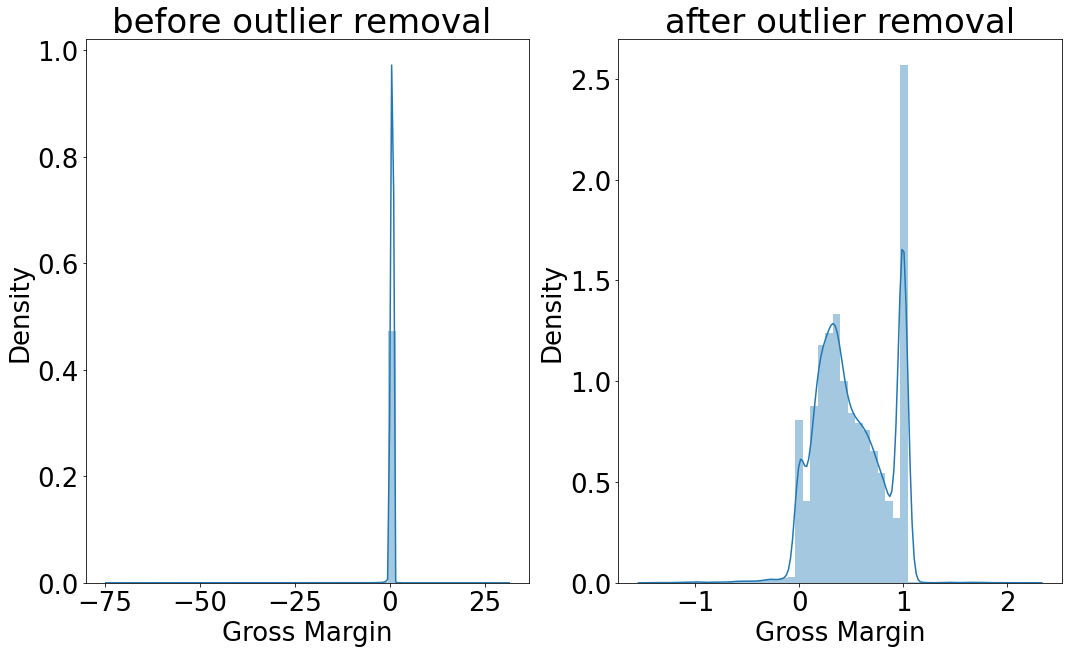

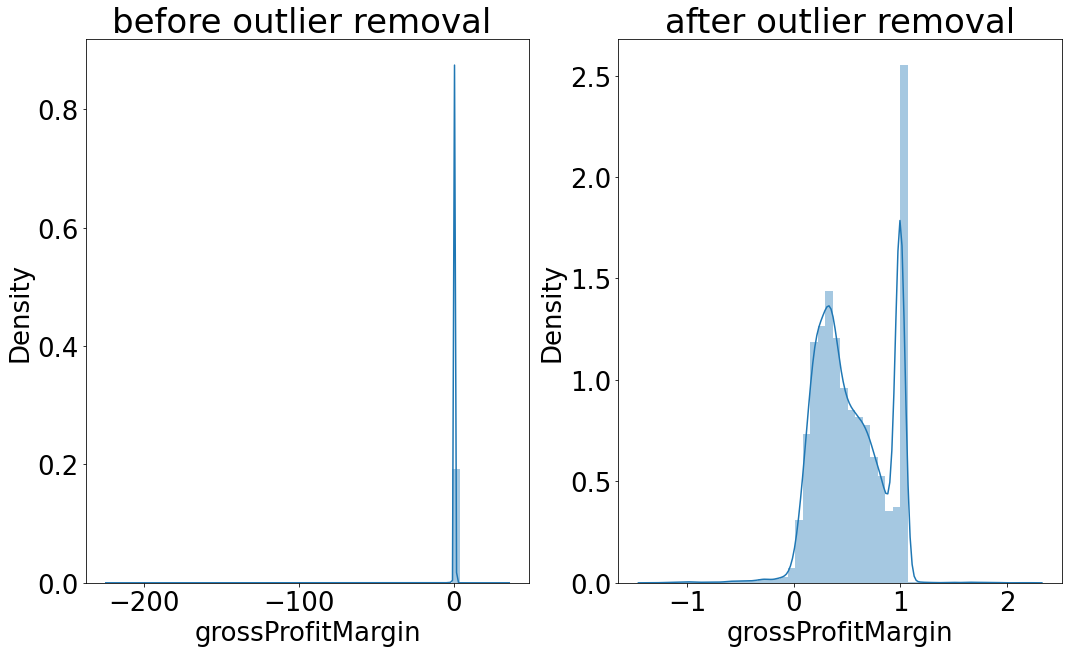

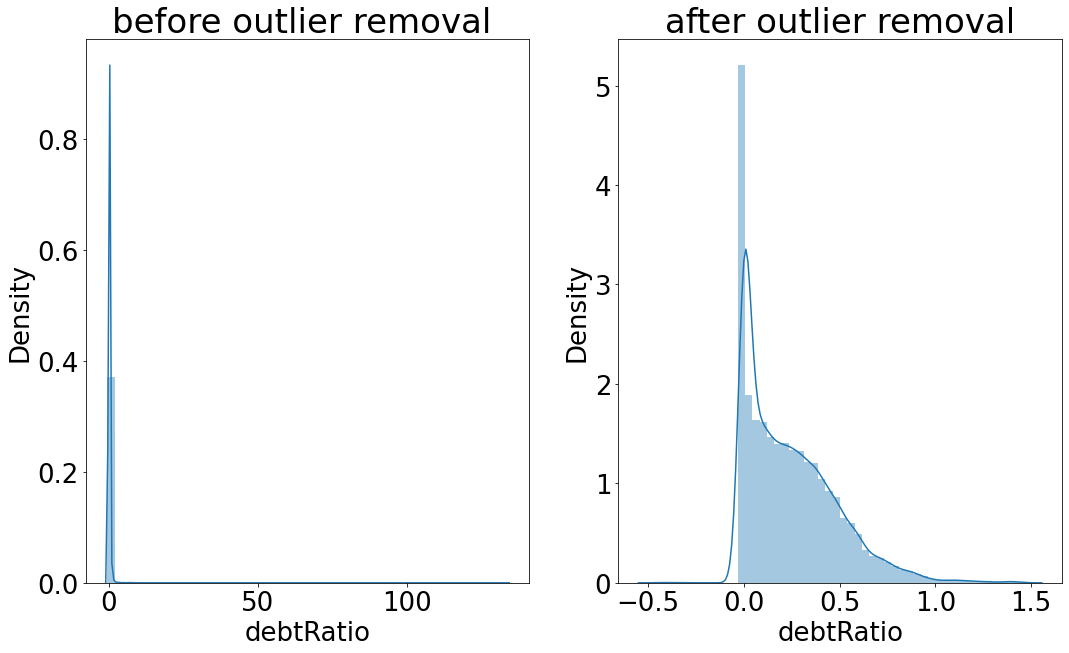

In [ ]:
df_outliers = df_14_18.copy()

for i,feature in enumerate(Outlier_Features_List):
  if i == 0:
    df_results = remove_outlier(df_outliers,feature,3,3) # Parameters (df, feature_name, iqr_multiplier, percentage_threshold)
  else:
    df_result = remove_outlier(df_results,feature,3,3) # Parameters (df, feature_name, iqr_multiplier, percentage_threshold)


## Dendogram

We use a dendogram to check the semantic quality of the data. The dendogram performs binary hierarchical clustering to produce a tree where each leaf is a feature, and features closer together in the tree are distributed more similarly than features which are far apart.

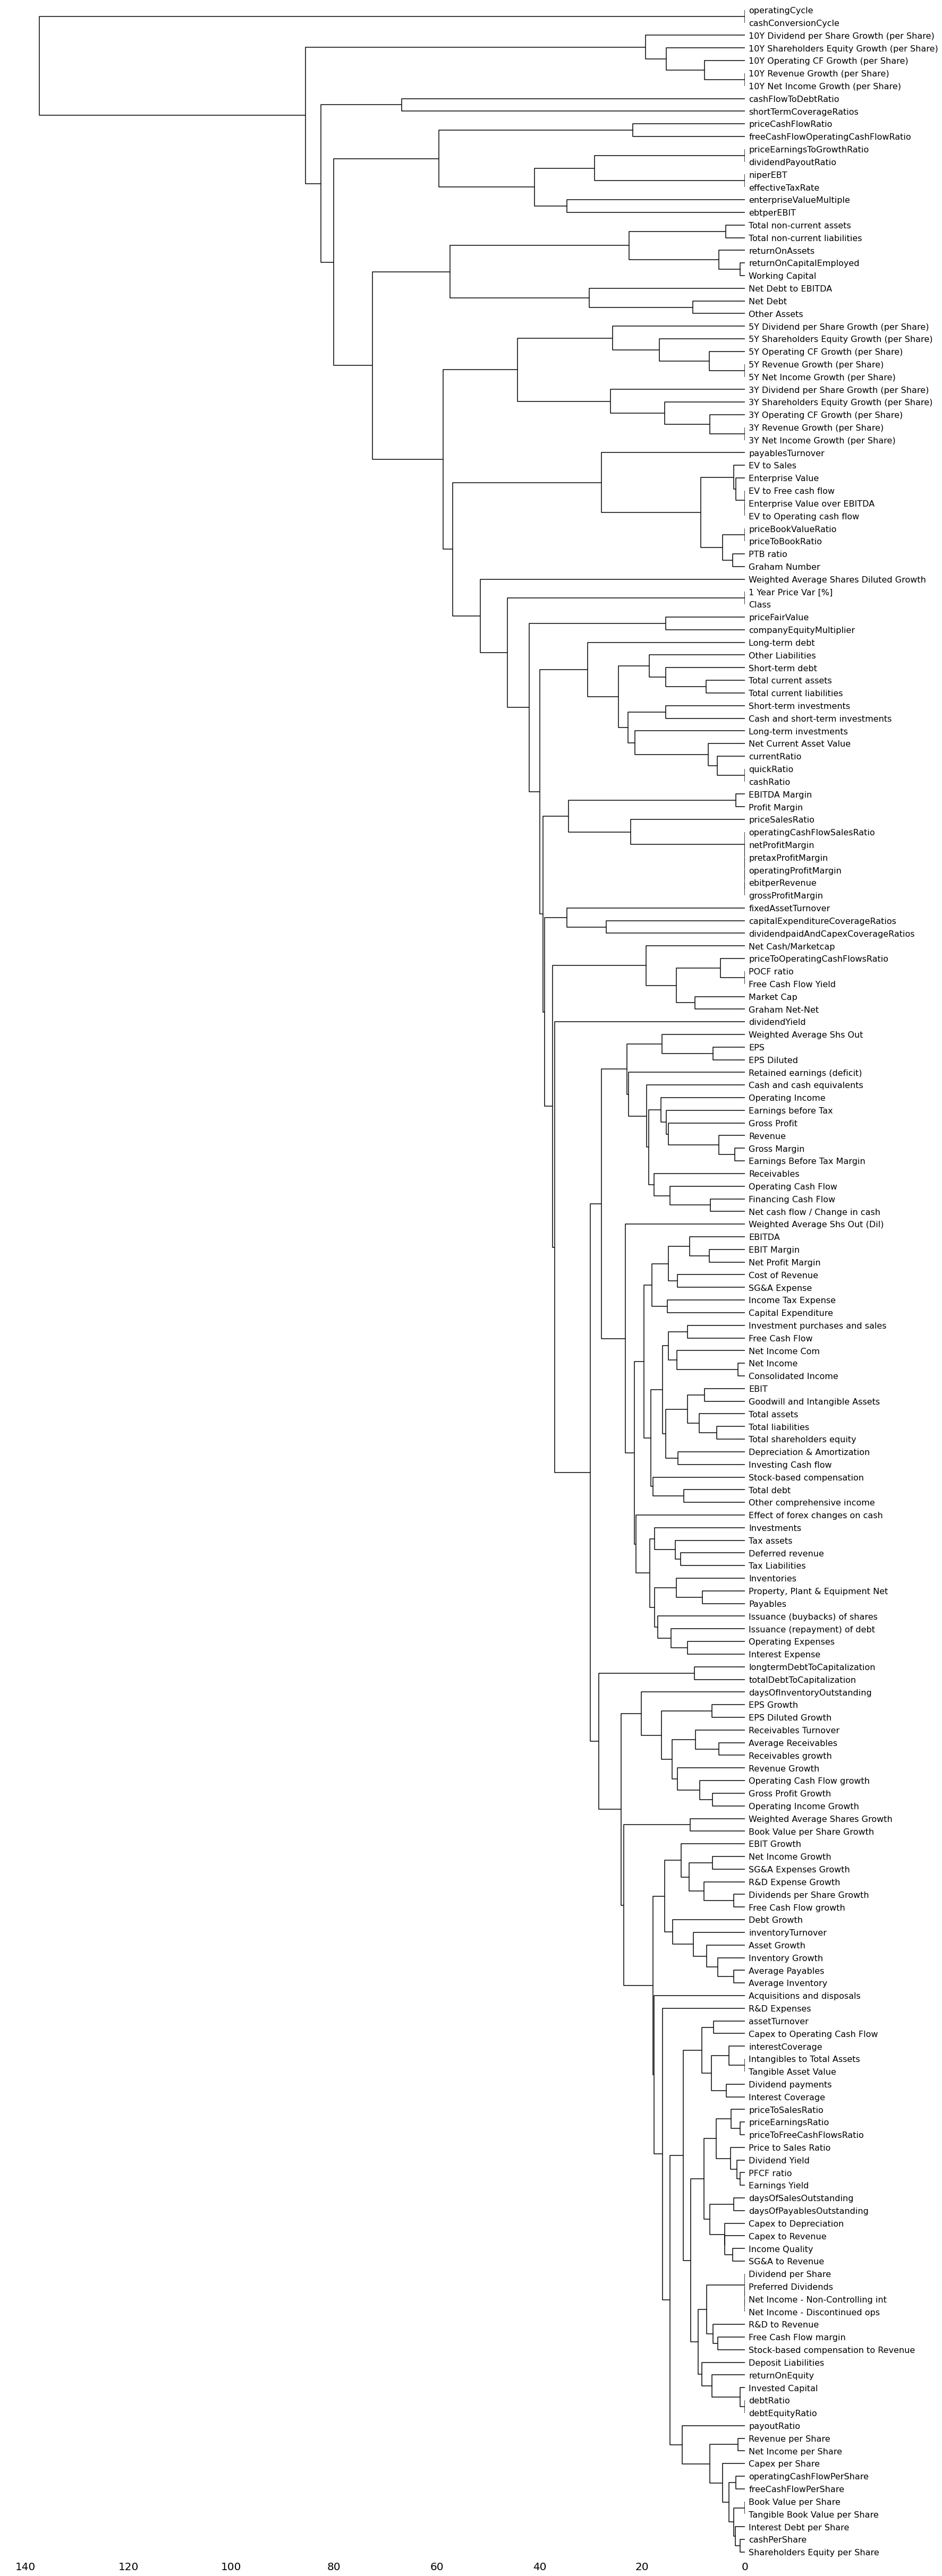

In [ ]:
msno.dendrogram(numerical_features)

## Checking Class Label Balance

In the following code, we visualize the distribution between positive and negative class throughout each year, and for the training and testing dataset.

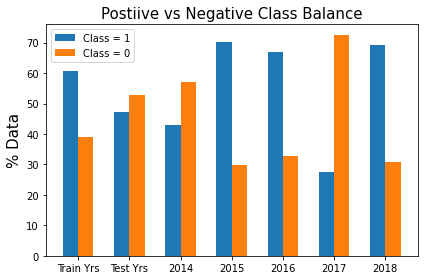

In [ ]:
#balance_plot_labels = ['All years']+year_list
balance_plot_labels = ['Train Yrs'] + ['Test Yrs'] + year_list

#get temporary train df
temp_train_df = df_14_18.loc[(df_14_18['Year of Data'] == '2014') | (df_14_18['Year of Data'] == '2015') | (df_14_18['Year of Data'] == '2016')]

temp_test_df = df_14_18.loc[(df_14_18['Year of Data'] == '2017') | (df_14_18['Year of Data'] == '2018')]

df_list_with_train_test = [temp_train_df] + [temp_test_df] + df_list

pos_class_percent = []
neg_class_percent = []

for df in df_list_with_train_test:

  pos_class_percent.append(len(df.loc[df['Class']==1])/len(df)*100)
  neg_class_percent.append(len(df.loc[df['Class']==0])/len(df)*100)


#code modified from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
x = np.arange(len(balance_plot_labels))
width = 0.3

fig_class_bal,ax_class_bal = plt.subplots()
rects1 = ax_class_bal.bar(x - width/2, pos_class_percent, width, label = "Class = 1")
rects2 = ax_class_bal.bar(x + width/2, neg_class_percent, width, label = "Class = 0")

ax_class_bal.set_ylabel('% Data')
ax_class_bal.set_title("Postiive vs Negative Class Balance")
ax_class_bal.set_xticks(x)
ax_class_bal.set_xticklabels(balance_plot_labels)
ax_class_bal.legend()

ax_class_bal.title.set_fontsize(15)
ax_class_bal.xaxis.label.set_fontsize(20)
ax_class_bal.yaxis.label.set_fontsize(15)

fig_class_bal.tight_layout()
plt.show()

##Check cardinality of categorical features

In [ ]:
list(categorical_features.columns)

['Year of Data', 'Ticker', 'Sector']

In [ ]:
categorical_features['Sector'].value_counts()

Financial Services        4720
Healthcare                3305
Technology                3126
Industrials               2768
Consumer Cyclical         2471
Basic Materials           1344
Real Estate               1241
Energy                    1217
Consumer Defensive         922
Utilities                  518
Communication Services     445
Name: Sector, dtype: int64

In [ ]:
lowest_sector_freq = (len(categorical_features['Sector'].loc[(categorical_features['Sector'] == 'Communication Services')])/len(categorical_features)*100)
lowest_sector_cnt = len(categorical_features['Sector'].loc[(categorical_features['Sector'] == 'Communication Services')])
print(f'Least common Sector label occurs {lowest_sector_cnt} times or {lowest_sector_freq} % of the time.')

Least common Sector label occurs 445 times or 2.015672419259863 % of the time.


Cardinality of 'Sector' values is 11, with the least common feature label assigned to 

##Correlation Analysis

In this section, we analyze the correlation between features. The purpose of this section is to remove any features that are to highly correlated.

In [ ]:
def remove_high_corr(df,thresh):
  #return a copy of df (containing numerical features only) in which if two features are highly correlated (coef. above thresh), one of the two features is randomly deleted
  #also return the highly correlated cols 
  #snippet modified from: https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python#mcetoc_1g0c4fnd49
  
  df = df.copy()

  #get corelation matrix
  corr = df.corr()

  #get upper triangular matrix
  upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))

  #get features with at least one correlation coeff (abs value) with another feature is above thresh
  high_corr_cols = [col for col in upper_tri.columns if any(abs(upper_tri[col]) > thresh)]

  print(f'Removing {len(high_corr_cols)} numerical features.')

  df = df.drop(columns = high_corr_cols)

  print(f'There are {len(df.columns)} numerical features remaining.')

  return df, high_corr_cols

In [ ]:
#delete correlated features, get list of features that were deleted
numerical_features_corr_rem, highly_corr_feats = remove_high_corr(numerical_features,0.9)

Removing 73 numerical features.
There are 129 numerical features remaining.


In [ ]:
highly_corr_feats

['Cost of Revenue',
 'Operating Expenses',
 'Net Income',
 'Net Income Com',
 'EPS Diluted',
 'Weighted Average Shs Out (Dil)',
 'Profit Margin',
 'Free Cash Flow margin',
 'EBITDA',
 'EBIT',
 'Consolidated Income',
 'Earnings Before Tax Margin',
 'Net Profit Margin',
 'Total assets',
 'Total current liabilities',
 'Long-term debt',
 'Total debt',
 'Deferred revenue',
 'Tax Liabilities',
 'Deposit Liabilities',
 'Total non-current liabilities',
 'Total liabilities',
 'Other comprehensive income',
 'Investments',
 'Net Debt',
 'Other Liabilities',
 'priceToBookRatio',
 'priceCashFlowRatio',
 'priceSalesRatio',
 'ebitperRevenue',
 'pretaxProfitMargin',
 'netProfitMargin',
 'effectiveTaxRate',
 'returnOnEquity',
 'cashRatio',
 'daysOfSalesOutstanding',
 'operatingCycle',
 'cashConversionCycle',
 'totalDebtToCapitalization',
 'companyEquityMultiplier',
 'operatingCashFlowSalesRatio',
 'freeCashFlowOperatingCashFlowRatio',
 'Net Income per Share',
 'Tangible Book Value per Share',
 'Price t

In [ ]:
#Find a highly correlated pair of features to visualize
def find_highly_correlated_pair(df,thresh):
  #find a pair of features which have a correlation coefficient above thresh
  #snippet modified from: https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python#mcetoc_1g0c4fnd49
  
  df = df.copy()

  #get corelation matrix
  corr = df.corr()

  #get upper triangular matrix
  upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))

  cnt = 0
  
  while cnt <= 10:
    for i in range(len(upper_tri.index)):
      for j in range(len(upper_tri.columns)):
        if upper_tri.iloc[i,j] >= thresh and i != 0 and i != 1:
          print(i,j)
          cnt += 1

  #find an entry above where coef above thresh
  #for i in range upper_tri.shape[0]

In [ ]:
#plot cols contains two highly correlated cols
df_for_scatter_plot = df_14_18.iloc[:,[9,15]]

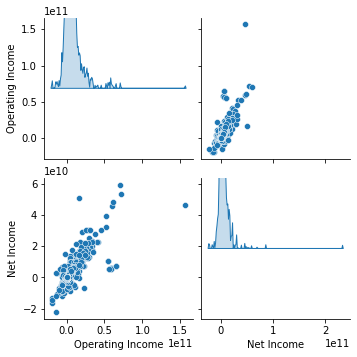

In [ ]:
sns.pairplot(df_for_scatter_plot, kind = 'scatter', diag_kind = 'kde')
plt.show()

In [ ]:
df_14_18_reduced = df_14_18.drop(columns=[ x for x in highly_corr_feats[:-1] if x in df_14_18.columns])

## Filling Missing Values

In this section, we seperated the categorical and numerical features. We then imputed values and merge  back the tables.

### Filling Categorical Features

In [ ]:
# We will go over column that are datatype str
column_str = []
for column in df_14_18:
  if df_14_18[column].dtype == object:
    column_str.append(column)

In [ ]:
for column in column_str: 
  print(f" The number of Na value in {column} is {(df_14_18[column].isna().sum())}")

 The number of Na value in Year of Data is 0
 The number of Na value in Ticker is 0
 The number of Na value in Sector is 0


There is no missing values for the features above.

### Filling Numerical Features

In [ ]:
# Remove categorical data
df_14_18_num = df_14_18.select_dtypes(exclude=['object']).copy()
imputer = SimpleImputer(strategy="median") # we can easily change to mean, median, or most_frequent
imputer.fit(df_14_18_num)
X = imputer.transform(df_14_18_num)
df_14_18_num = pd.DataFrame(X, columns=df_14_18_num.columns,index=df_14_18_num.index)


### Merge Cat and Num tables

In [ ]:
df_14_18 = pd.merge(df_14_18[column_str],df_14_18_num,left_index = True, right_index=True)
df_14_18.head()

,Year of Data,Ticker,Sector,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,1 Year Price Var [%],Class
16477,2017,PYN,Financial Services,4.352510e+08,0.0576,153011500.0,1.943525e+08,0.0,80624500.0,1.564000e+08,...,0.0000,0.0095,0.0000,0.0480,0.0324,0.0000,0.0000,0.0610,-7.660304,0.0
14825,2017,JASN,Industrials,6.486160e+08,-0.0807,517764000.0,1.308520e+08,0.0,103855000.0,1.073620e+08,...,0.0000,-0.1183,-0.0378,-0.0643,2.6148,-0.0556,0.0000,-0.0874,-43.621401,0.0
18794,2018,RMD,Healthcare,2.340196e+09,0.1323,978032000.0,1.362164e+09,155149000.0,600369000.0,8.203330e+08,...,0.0772,0.0736,0.0014,-0.1166,0.0400,-0.7391,0.0739,0.0838,40.435954,1.0
18162,2018,CXO,Energy,4.151000e+09,0.6052,950000000.0,3.201000e+09,65000000.0,311000000.0,1.103000e+09,...,0.0000,0.5304,1.5000,0.9148,0.5632,0.4115,0.1017,0.2746,-17.440006,0.0
12654,2016,COCP,Technology,0.000000e+00,-1.0000,0.0,0.000000e+00,101679000.0,4140000.0,1.058190e+08,...,0.0000,-0.3438,0.0000,-0.4431,-0.4545,0.0000,1.1514,-0.3880,-48.717948,0.0


In [ ]:
column_str = []
for column in df_14_18_reduced:
  if df_14_18_reduced[column].dtype == object:
    column_str.append(column)
# Remove categorical data
df_14_18_reduced_num = df_14_18_reduced.select_dtypes(exclude=['object']).copy()
imputer = SimpleImputer(strategy="median") # we can easily change to mean, median, or most_frequent
imputer.fit(df_14_18_reduced_num)
X = imputer.transform(df_14_18_reduced_num)
df_14_18_reduced_num = pd.DataFrame(X, columns=df_14_18_reduced_num.columns,index=df_14_18_reduced_num.index)
df_14_18_reduced = pd.merge(df_14_18_reduced[column_str],df_14_18_reduced_num,left_index = True, right_index=True)
df_14_18_reduced.head()


,Year of Data,Ticker,Sector,Revenue,Revenue Growth,Gross Profit,R&D Expenses,SG&A Expense,Operating Income,Interest Expense,...,5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Book Value per Share Growth,Debt Growth,R&D Expense Growth,1 Year Price Var [%],Class
16477,2017,PYN,Financial Services,4.352510e+08,0.0576,1.943525e+08,0.0,80624500.0,3.585350e+07,3697000.0,...,0.0315,0.0264,0.0,0.0000,0.0000,0.0324,0.0000,0.0000,-7.660304,0.0
14825,2017,JASN,Industrials,6.486160e+08,-0.0807,1.308520e+08,0.0,103855000.0,2.349000e+07,33089000.0,...,0.0315,0.0264,0.0,0.0000,0.0000,2.6148,-0.0556,0.0000,-43.621401,0.0
18794,2018,RMD,Healthcare,2.340196e+09,0.1323,1.362164e+09,155149000.0,600369000.0,5.418310e+08,28355000.0,...,0.0506,0.0847,0.0,0.1554,0.0772,0.0400,-0.7391,0.0739,40.435954,1.0
18162,2018,CXO,Energy,4.151000e+09,0.6052,3.201000e+09,65000000.0,311000000.0,2.098000e+09,149000000.0,...,0.2125,0.2036,0.0,0.0000,0.0000,0.5632,0.4115,0.1017,-17.440006,0.0
12654,2016,COCP,Technology,0.000000e+00,-1.0000,0.000000e+00,101679000.0,4140000.0,-1.058190e+08,-126000.0,...,0.0000,0.0000,0.0,0.0000,0.0000,-0.4545,0.0000,1.1514,-48.717948,0.0


# PCA 

In this section, we create a model to use the PCA method on our dataset. This is used later on in the report to compare it to the baseline model.

## PCA Visualization

The following code was used to visualize how many components would represent 95% variance. It is to note that a common threshold is between 95-99%, we chose to keep 95% as our threshold: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/.

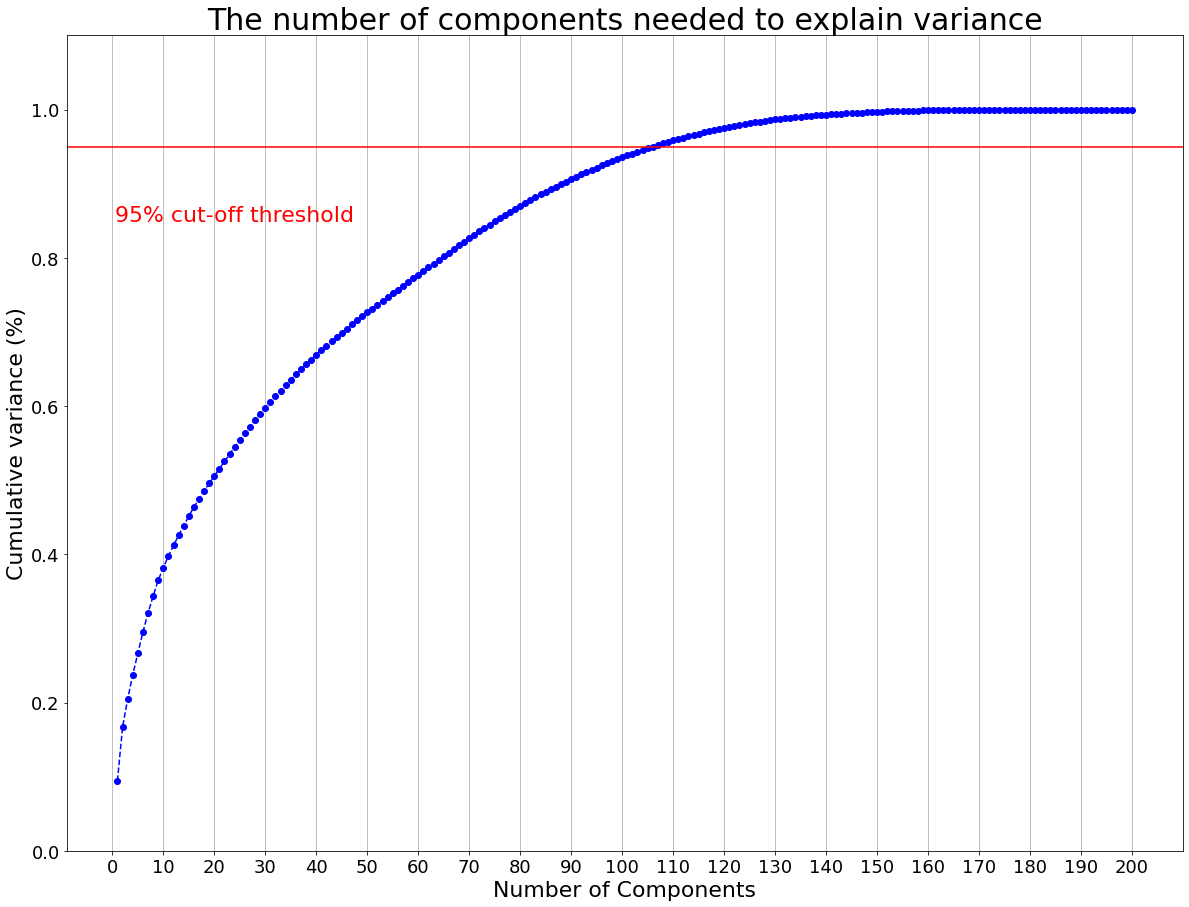

In [ ]:
# Code modified: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
# Plot the required number of components
df_PCA = df_14_18_num.copy()
std_slc = StandardScaler()
X_std = std_slc.fit_transform(df_PCA)

pca = PCA().fit(X_std)

plt.rcParams["figure.figsize"] = (20,15)

fig,ax = plt.subplots()
xi = np.arange(1,201, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components',fontdict={'fontsize': 22})
plt.ylabel('Cumulative variance (%)', fontdict={'fontsize': 22})

plt.xticks(np.arange(0, 201, step=10),fontsize=18) #change from 0-based array index to 1-based human-readable label
plt.yticks(fontsize=18) 

plt.title('The number of components needed to explain variance', fontdict={'fontsize': 30})
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=22)

ax.grid(axis='x')
plt.show()

Using the results from the graph, we can say that it would take around 110 principal components to represents 95% variance. 

## PCA Model

In this section, we fit PCA to our table. We later use the PCA model to compare it against the baseline model.

In [ ]:
pca = PCA(n_components=0.95, whiten=True)
pca.fit(X_std)
X_PCA = pca.transform(X_std)
X_PCA.shape
print(f'The number of features went from {df_14_18_num.shape[1]} features to {X_PCA.shape[1]}')

The number of features went from 200 features to 107


We can see that 95% of the variance can be explained from 107 features.

# Training Major Models

## Prepare Data for Training

### Function to calculate stock gain/loss over years

The following function calculates if a stock performs well or not after a certain number of years. 

In [ ]:
# Input year range ex: 2014 - 2018
def ticker_result(data_df, start_year,end_year):
  data_df.copy()

  desired_year = []
  for year in range(start_year, end_year):
      desired_year.append(str(year))

  unique_ticker = data_df['Ticker'].unique().tolist()
  dict_ticker = {}
  for tick in unique_ticker:
    dict_ticker[tick] = None

  for ticker in unique_ticker:
    variation = data_df[data_df['Year of Data'].isin(desired_year) & (data_df['Ticker']==ticker)]['1 Year Price Var [%]']
    total_var = 1
    for year_var in variation:
        year_var = year_var/100
        if year_var < 0:
          year_var = (1 + year_var) # Adding negative value
        else:
          year_var = 1 + year_var
        total_var *= year_var

    if total_var > 1:
      result = 1
    else:
      result = 0
    
    dict_ticker[ticker] = result    
  return dict_ticker 



### Function to prepare the features and targets for a range of years

In [ ]:
# return the features and labels
# multi_year_target is used for test data years to have multiple years final target (e.g. if years is 2016-2018, the resulting dataframe will only have 2016 input data with labels of the three-year performance)
def get_data_by_years(df, years, multi_year_target=False):
  dfs = []
  for year in years:
    dfs.append(df[df['Year of Data'] == str(year)].copy())
  concatenated = pd.concat(dfs)
  if multi_year_target:
    new_targets = ticker_result(concatenated, years[0],years[-1])
    concatenated = df[df['Year of Data'] == str(years[0])]
    for ticker, new_class in new_targets.items():
      concatenated.loc[concatenated.Ticker == ticker, 'Class'] = new_class
      
  # drop columns not used for classification
  concatenated = concatenated.drop(columns=["1 Year Price Var [%]", "Ticker", "Year of Data"])
  return concatenated.drop(columns=["Class"]), concatenated["Class"]

### Function to prepare the data for training including train and test data splits and normalization

The following function prepares the data into training and testing based on the input. It can split the data for our baseline model, for a time horizon analysis, and for the PCA analysis.

In [ ]:
def prepare_data_for_training(classification_df, train_years=[2014, 2015, 2016], test_years=[2017, 2018], test_multi_year=False, return_unnormalized=False, apply_pca=False):
  # add one hot encoding of the sector categorical feature
  classification_df = pd.get_dummies(classification_df, columns=['Sector'])

  # divide into training and test data
  train_X, train_y = get_data_by_years(classification_df, train_years)
  test_X, test_y = get_data_by_years(classification_df, test_years, multi_year_target=test_multi_year)
  unnormalized = [train_X.reset_index(drop=True), test_X.reset_index(drop=True)]
  # Normalize 
  scaler = StandardScaler()
  columns_to_normalize = [x for x in list(train_X) if not x.startswith('Sector')]
 

  train_X_arr_partial = train_X[columns_to_normalize].values
  train_X_arr_partial_scaled = scaler.fit_transform(train_X_arr_partial)
  train_X[columns_to_normalize] = pd.DataFrame(train_X_arr_partial_scaled, columns=columns_to_normalize, index=train_X.index)

  test_X_arr_partial = test_X[columns_to_normalize].values
  test_X_arr_partial_scaled = scaler.transform(test_X_arr_partial)
  test_X[columns_to_normalize] = pd.DataFrame(test_X_arr_partial_scaled, columns=columns_to_normalize, index=test_X.index)

  if apply_pca:
    pca = PCA(n_components=0.95, whiten=True)
    pca.fit(train_X)
    train_X = pca.transform(train_X)
    test_X = pca.transform(test_X)
    print("Shape of Train set with PCA is ", train_X.shape)
    return train_X, train_y.values, test_X, test_y.values, list(train_X)
  
  if return_unnormalized:
    return train_X.values, train_y.values, test_X.values, test_y.values, unnormalized
  return train_X.values, train_y.values, test_X.values, test_y.values, list(train_X)

### Function to compare the major metrics

The following function is used to calculate different metrics of each models (Accuracy, F1-Score, Precision, NPV, Recall, and Specificity)

In [ ]:
def compare_metrics(models, test_data, test_labels, model_names, different_data=False):
  accuracy_list, f1_list, precision_list, recall_list, specificity_list, npv_list = [], [], [], [], [], []
  for i, model in enumerate(models):
    if different_data:
      data=test_data[i]
      labels=test_labels[i]
    else:
      data = test_data
      labels=test_labels
    preds = model.predict(data)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    f1_list.append((2*tp)/(2*tp+fp+fn))
    specificity_list.append(tn / (tn+fp))
    npv_list.append(tn / (tn+fn))
    accuracy_list.append(accuracy_score(labels, preds))
    precision_list.append(precision_score(labels, preds))
    recall_list.append(recall_score(labels, preds))
  info = [model_names, accuracy_list, f1_list, precision_list, npv_list, recall_list, specificity_list]
  info_t = pd.DataFrame(info).T.values.tolist()
  print(tabulate(info_t, headers=["Model", "Accuracy", "F1-Score", "Precision", "NPV", "Recall", "Specificity"]))

## Random Forest Baseline

### Training and Hyperparameter Tuning
In this section we apply gridsearch to find the best hyperparameter:

* The two chosen hyperparameters are:
  * The number of max features per tree
  * The number of trees in the Random Forest
* The hyperparameters chosen maximizes the F1-Scores on a 4-fold cross validation strategy




In [ ]:
classification_df = df_14_18.copy()

train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df)

param_grid = {'max_features': [4, 10, "sqrt", 80, len(feature_names)],
              'n_estimators': [64, 128, 512, 1024, 2500],
              }
# param_grid = {'max_features': ["sqrt"],
#               'n_estimators': [100],
#               }
rf_classifier = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, scoring='f1', verbose=3, cv=4)
rf_classifier.fit(train_X, train_y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV 1/4] END ...max_features=4, n_estimators=64;, score=0.651 total time=   2.0s
[CV 2/4] END ...max_features=4, n_estimators=64;, score=0.712 total time=   2.5s
[CV 3/4] END ...max_features=4, n_estimators=64;, score=0.752 total time=   2.1s
[CV 4/4] END ...max_features=4, n_estimators=64;, score=0.733 total time=   2.8s
[CV 1/4] END ..max_features=4, n_estimators=128;, score=0.651 total time=   5.6s
[CV 2/4] END ..max_features=4, n_estimators=128;, score=0.725 total time=   4.0s
[CV 3/4] END ..max_features=4, n_estimators=128;, score=0.750 total time=   4.0s
[CV 4/4] END ..max_features=4, n_estimators=128;, score=0.736 total time=   3.9s
[CV 1/4] END ..max_features=4, n_estimators=512;, score=0.659 total time=  18.9s
[CV 2/4] END ..max_features=4, n_estimators=512;, score=0.728 total time=  13.7s
[CV 3/4] END ..max_features=4, n_estimators=512;, score=0.759 total time=  14.5s
[CV 4/4] END ..max_features=4, n_estimators=512

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_features': [4, 10, 'sqrt', 80, 209],
                         'n_estimators': [64, 128, 512, 1024, 2500]},
             scoring='f1', verbose=3)

In [ ]:
print(rf_classifier.best_score_)
print(rf_classifier.best_params_)

0.72440835406835
{'max_features': 4, 'n_estimators': 2500}


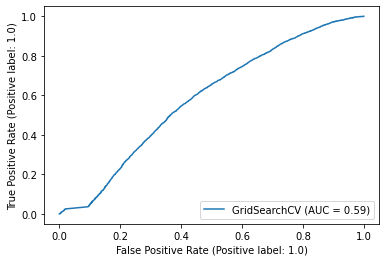

In [ ]:
RocCurveDisplay.from_estimator(rf_classifier, test_X, test_y)

In [ ]:
compare_metrics([rf_classifier], test_X, test_y, ["RF"])

Model      Accuracy    F1-Score    Precision       NPV    Recall    Specificity
-------  ----------  ----------  -----------  --------  --------  -------------
RF          0.54908    0.643262     0.513437  0.684643   0.86096       0.270057


### Hyperparameter Sensitivity

In this section, we look at the sensitivity of the best hyperparemeters from the gridsearch when subject to +/- 80% change. 

In [ ]:
CHOSEN_MAX_FEATURES = 4
CHOSEN_N_ESTIMATORS = 2500
CHANGE_PERCENT = 80

train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df)

param_grid = {'max_features': [int(CHOSEN_MAX_FEATURES*CHANGE_PERCENT/100), CHOSEN_MAX_FEATURES, int(CHOSEN_MAX_FEATURES*(1+CHANGE_PERCENT/100))],
              'n_estimators': [int(CHOSEN_N_ESTIMATORS*CHANGE_PERCENT/100), CHOSEN_N_ESTIMATORS, int(CHOSEN_N_ESTIMATORS*(1+CHANGE_PERCENT/100))],
              }

f1_scores = np.empty((3,3))
for i, param_1 in enumerate(param_grid['max_features']):
  for j, param_2 in enumerate(param_grid['n_estimators']):
    cls = RandomForestClassifier(random_state=0, max_features=param_1, n_estimators=param_2)
    cls.fit(train_X, train_y)
    f1_scores[i][j] = f1_score(test_y, cls.predict(test_X))

print(f1_scores)

[[0.64176456 0.64070288 0.64299002]
 [0.64227642 0.64326199 0.64234318]
 [0.64105825 0.64046851 0.6423914 ]]


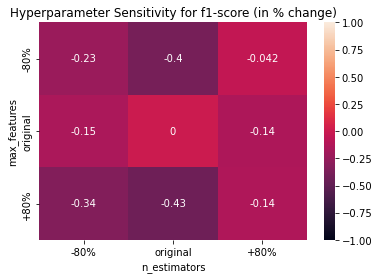

In [ ]:
f1_scores_df = pd.DataFrame(data=(f1_scores/f1_scores[1][1]-1)*100, index=[f'-{CHANGE_PERCENT}%', 'original', f'+{CHANGE_PERCENT}%'], columns=[f'-{CHANGE_PERCENT}%', 'original', f'+{CHANGE_PERCENT}%'])
ax = sns.heatmap(f1_scores_df, vmin=-1, vmax=1, annot=True)
ax.set_xlabel(list(param_grid.keys())[1])
ax.set_ylabel(list(param_grid.keys())[0])
ax.set_title('Hyperparameter Sensitivity for f1-score (in % change)')
plt.show()

In [ ]:
classification_df = df_14_18.copy()
train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df)
rf_cls = RandomForestClassifier(random_state=0, max_features=4, n_estimators=2500)
rf_cls.fit(train_X, train_y)

RandomForestClassifier(max_features=4, n_estimators=2500, random_state=0)

## MLP Baseline

### Training and Hyperparameter Tuning

In this section we apply gridsearch to find the best hyperparameter:

* The four chosen hyperparameters are:
  * The hidden layer size
  * The activation function The activation function
  * Batch Size
  * Learning Rate
* The hyperparameters chosen maximizes the F1-Scores on a 5-fold cross validation strategy
* A grid search is done over 5 options per each hyperparameter considered in the search


In [ ]:
classification_df = df_14_18.copy()

train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df)

#Neural Architectures
arch1 = (50)*3
arch2 = (50)*4
arch3 = (50,30,50)
arch4 = (100)*3
arch5 = (50,30,30,50)

arch_list = [arch1,arch2,arch3,arch4,arch5]

mlp_param_grid = {'hidden_layer_sizes': arch_list,
                  'activation': ["relu",'logistic'],
                  'batch_size': [50,200],
                  'learning_rate' : ['constant','adaptive']
                 }

In [ ]:
mlp = GridSearchCV(MLPClassifier(random_state = 42, max_iter = 100, early_stopping = True), mlp_param_grid, verbose=3, scoring='f1', cv=5)
mlp.fit(train_X, train_y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END activation=relu, batch_size=50, hidden_layer_sizes=150, learning_rate=constant;, score=0.716 total time=   5.0s
[CV 2/5] END activation=relu, batch_size=50, hidden_layer_sizes=150, learning_rate=constant;, score=0.717 total time=   4.3s
[CV 3/5] END activation=relu, batch_size=50, hidden_layer_sizes=150, learning_rate=constant;, score=0.720 total time=   7.7s
[CV 4/5] END activation=relu, batch_size=50, hidden_layer_sizes=150, learning_rate=constant;, score=0.746 total time=   6.2s
[CV 5/5] END activation=relu, batch_size=50, hidden_layer_sizes=150, learning_rate=constant;, score=0.727 total time=   5.7s
[CV 1/5] END activation=relu, batch_size=50, hidden_layer_sizes=150, learning_rate=adaptive;, score=0.716 total time=   5.1s
[CV 2/5] END activation=relu, batch_size=50, hidden_layer_sizes=150, learning_rate=adaptive;, score=0.717 total time=   4.6s
[CV 3/5] END activation=relu, batch_size=50, hidden_layer_sizes

GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True, max_iter=100,
                                     random_state=42),
             param_grid={'activation': ['relu', 'logistic'],
                         'batch_size': [50, 200],
                         'hidden_layer_sizes': [150, 200, (50, 30, 50), 300,
                                                (50, 30, 30, 50)],
                         'learning_rate': ['constant', 'adaptive']},
             scoring='f1', verbose=3)

In [ ]:
print(mlp.best_score_)
print(mlp.best_params_)

0.7353737209453073
{'activation': 'logistic', 'batch_size': 200, 'hidden_layer_sizes': 200, 'learning_rate': 'constant'}


The best score was {'activation': 'logistic', 'batch_size': 200, 'hidden_layer_sizes': 200, 'learning_rate': 'constant'} . The architecture corresponding to this hidden layer size is (50,50,50,50).

###Hyperparameter Sensitivity

In this section, we look at the sensitivity of the best hyperparemeters from the gridsearch when subject to +/- 80% change. 

In [ ]:
param_grid = {'hidden_layer_sizes': [(10,10,10,10), (50,50,50,50), (90,90,90,90)],
              'batch_size': [40,200,360],
              }

f1_scores = np.empty((3,3))
for i, param_1 in enumerate(param_grid['hidden_layer_sizes']):
  for j, param_2 in enumerate(param_grid['batch_size']):
    cls = MLPClassifier(random_state = 42, max_iter = 100, early_stopping = True, hidden_layer_sizes = param_1, activation = 'logistic', batch_size = param_2, learning_rate = 'constant')
    cls.fit(train_X, train_y)
    f1_scores[i][j] = f1_score(test_y, cls.predict(test_X))

print(f1_scores)

[[0.63387245 0.63706721 0.64148751]
 [0.63088829 0.62435886 0.6286981 ]
 [0.62970196 0.63100253 0.62836625]]


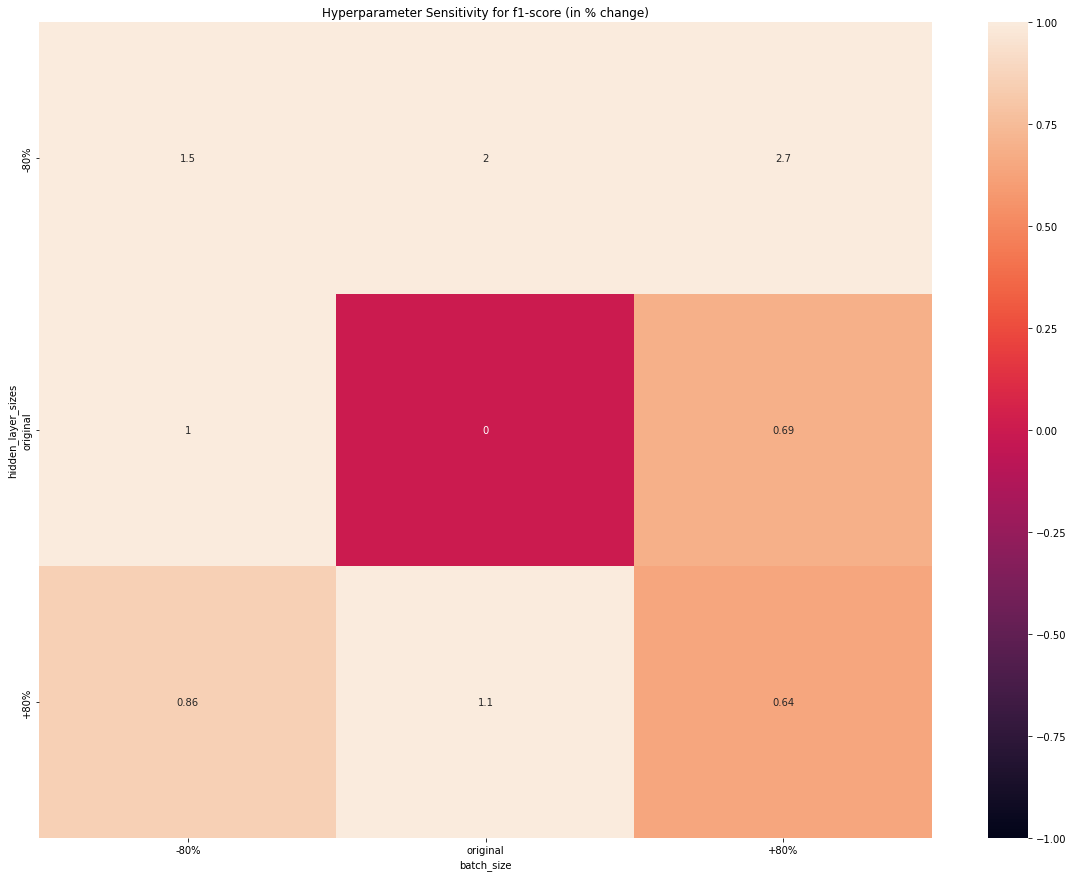

In [ ]:
#Heatmap for 80% changes to hyper params
f1_scores_df = pd.DataFrame(data=(f1_scores/f1_scores[1][1]-1)*100, index=[f'-{80}%', 'original', f'+{80}%'], columns=[f'-{80}%', 'original', f'+{80}%'])
ax = sns.heatmap(f1_scores_df, vmin=-1, vmax=1, annot=True)
ax.set_xlabel(list(param_grid.keys())[1])
ax.set_ylabel(list(param_grid.keys())[0])
ax.set_title('Hyperparameter Sensitivity for f1-score (in % change)')
plt.show()

In [ ]:
#Fit best model
mlp_classifier = MLPClassifier(random_state = 42, max_iter = 100, early_stopping = True, hidden_layer_sizes = (50)*4, activation = 'logistic', batch_size = 200, learning_rate = 'constant')
mlp_classifier.fit(train_X, train_y)

MLPClassifier(activation='logistic', batch_size=200, early_stopping=True,
              hidden_layer_sizes=200, max_iter=100, random_state=42)

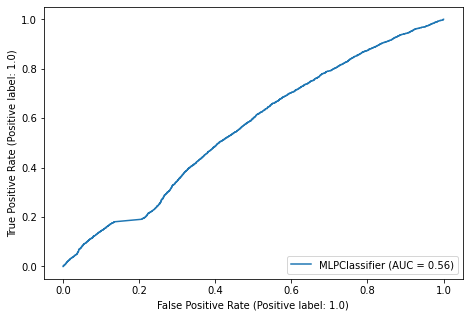

In [ ]:
plt.rcParams["figure.figsize"] = (7.5,5)
RocCurveDisplay.from_estimator(mlp_classifier, test_X, test_y)

In [ ]:
#get dataframe and best params
mlp_cv_df = pd.DataFrame(mlp.cv_results_).sort_values(by = ['mean_test_score'], ascending = False).loc[:,['params','mean_test_score']]
mlp_cv_df

## SVM Baseline

### Training and Hyperparameter Tuning

In this section we apply gridsearch to find the best hyperparameter:

* The three chosen hyperparameters are:
  * C (regularization parameter)
  * gamma 
  * Kernel
* The hyperparameters chosen maximizes the F1-Scores on a 4-fold cross validation strategy



In [ ]:
classification_df = df_14_18.copy()
train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df)

param_grid = {'C': [0.01,1,100],
              'gamma': [0.01,1,100],
              'kernel': ['rbf','poly','sigmoid']
              }
svm_model = GridSearchCV(SVC(max_iter = 5000),param_grid,scoring='f1',verbose =3, cv=4)
svm_model.fit(train_X,train_y)
svm_model.score(test_X, test_y)
y_pred = svm_model.predict(test_X)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.757 total time=  28.7s
[CV 2/4] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.756 total time=  26.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.757 total time=  28.4s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.757 total time=  27.3s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ...C=0.01, gamma=0.01, kernel=poly;, score=0.755 total time=  17.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ...C=0.01, gamma=0.01, kernel=poly;, score=0.755 total time=  15.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ...C=0.01, gamma=0.01, kernel=poly;, score=0.757 total time=  16.0s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ...C=0.01, gamma=0.01, kernel=poly;, score=0.755 total time=  16.7s
[CV 1/4] END C=0.01, gamma=0.01, kernel=sigmoid;, score=0.756 total time=  23.2s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END C=0.01, gamma=0.01, kernel=sigmoid;, score=0.754 total time=  22.0s
[CV 3/4] END C=0.01, gamma=0.01, kernel=sigmoid;, score=0.753 total time=  23.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END C=0.01, gamma=0.01, kernel=sigmoid;, score=0.754 total time=  22.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END .......C=0.01, gamma=1, kernel=rbf;, score=0.757 total time=  28.4s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END .......C=0.01, gamma=1, kernel=rbf;, score=0.756 total time=  28.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END .......C=0.01, gamma=1, kernel=rbf;, score=0.757 total time=  29.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END .......C=0.01, gamma=1, kernel=rbf;, score=0.757 total time=  26.9s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ......C=0.01, gamma=1, kernel=poly;, score=0.749 total time=   5.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ......C=0.01, gamma=1, kernel=poly;, score=0.750 total time=   5.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ......C=0.01, gamma=1, kernel=poly;, score=0.750 total time=   5.9s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ......C=0.01, gamma=1, kernel=poly;, score=0.749 total time=   5.2s
[CV 1/4] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.607 total time=  18.5s
[CV 2/4] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.597 total time=  17.2s
[CV 3/4] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.628 total time=  17.3s
[CV 4/4] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.665 total time=  20.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END .....C=0.01, gamma=100, kernel=rbf;, score=0.757 total time=  25.0s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END .....C=0.01, gamma=100, kernel=rbf;, score=0.756 total time=  23.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END .....C=0.01, gamma=100, kernel=rbf;, score=0.757 total time=  24.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END .....C=0.01, gamma=100, kernel=rbf;, score=0.757 total time=  24.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ....C=0.01, gamma=100, kernel=poly;, score=0.748 total time=   3.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ....C=0.01, gamma=100, kernel=poly;, score=0.750 total time=   3.0s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ....C=0.01, gamma=100, kernel=poly;, score=0.749 total time=   3.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ....C=0.01, gamma=100, kernel=poly;, score=0.751 total time=   3.5s
[CV 1/4] END .C=0.01, gamma=100, kernel=sigmoid;, score=0.621 total time=  10.7s
[CV 2/4] END .C=0.01, gamma=100, kernel=sigmoid;, score=0.637 total time=  11.5s
[CV 3/4] END .C=0.01, gamma=100, kernel=sigmoid;, score=0.596 total time=  12.0s
[CV 4/4] END .C=0.01, gamma=100, kernel=sigmoid;, score=0.562 total time=  10.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END .......C=1, gamma=0.01, kernel=rbf;, score=0.711 total time=  26.2s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END .......C=1, gamma=0.01, kernel=rbf;, score=0.751 total time=  23.3s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END .......C=1, gamma=0.01, kernel=rbf;, score=0.752 total time=  25.2s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END .......C=1, gamma=0.01, kernel=rbf;, score=0.748 total time=  23.0s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ......C=1, gamma=0.01, kernel=poly;, score=0.753 total time=  13.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ......C=1, gamma=0.01, kernel=poly;, score=0.754 total time=  16.6s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ......C=1, gamma=0.01, kernel=poly;, score=0.757 total time=  14.8s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ......C=1, gamma=0.01, kernel=poly;, score=0.754 total time=  14.2s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.662 total time=  17.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.650 total time=  19.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.693 total time=  17.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.647 total time=  17.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.742 total time=  25.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.739 total time=  27.8s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.759 total time=  24.8s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.741 total time=  26.9s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END .........C=1, gamma=1, kernel=poly;, score=0.749 total time=   3.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END .........C=1, gamma=1, kernel=poly;, score=0.751 total time=   3.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END .........C=1, gamma=1, kernel=poly;, score=0.753 total time=   3.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END .........C=1, gamma=1, kernel=poly;, score=0.751 total time=   3.1s
[CV 1/4] END ......C=1, gamma=1, kernel=sigmoid;, score=0.599 total time=  14.1s
[CV 2/4] END ......C=1, gamma=1, kernel=sigmoid;, score=0.585 total time=  13.7s
[CV 3/4] END ......C=1, gamma=1, kernel=sigmoid;, score=0.626 total time=  14.1s
[CV 4/4] END ......C=1, gamma=1, kernel=sigmoid;, score=0.658 total time=  17.0s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ........C=1, gamma=100, kernel=rbf;, score=0.757 total time=  25.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ........C=1, gamma=100, kernel=rbf;, score=0.755 total time=  23.8s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ........C=1, gamma=100, kernel=rbf;, score=0.756 total time=  25.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ........C=1, gamma=100, kernel=rbf;, score=0.754 total time=  24.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END .......C=1, gamma=100, kernel=poly;, score=0.748 total time=   3.3s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END .......C=1, gamma=100, kernel=poly;, score=0.750 total time=   4.0s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END .......C=1, gamma=100, kernel=poly;, score=0.749 total time=   3.4s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END .......C=1, gamma=100, kernel=poly;, score=0.751 total time=   3.1s
[CV 1/4] END ....C=1, gamma=100, kernel=sigmoid;, score=0.618 total time=  10.0s
[CV 2/4] END ....C=1, gamma=100, kernel=sigmoid;, score=0.632 total time=  10.0s
[CV 3/4] END ....C=1, gamma=100, kernel=sigmoid;, score=0.586 total time=  11.1s
[CV 4/4] END ....C=1, gamma=100, kernel=sigmoid;, score=0.555 total time=  10.3s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END .....C=100, gamma=0.01, kernel=rbf;, score=0.615 total time=  15.8s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END .....C=100, gamma=0.01, kernel=rbf;, score=0.656 total time=  14.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END .....C=100, gamma=0.01, kernel=rbf;, score=0.669 total time=  15.9s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END .....C=100, gamma=0.01, kernel=rbf;, score=0.680 total time=  15.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ....C=100, gamma=0.01, kernel=poly;, score=0.749 total time=  11.9s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ....C=100, gamma=0.01, kernel=poly;, score=0.748 total time=  13.9s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ....C=100, gamma=0.01, kernel=poly;, score=0.753 total time=  13.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ....C=100, gamma=0.01, kernel=poly;, score=0.752 total time=  13.4s
[CV 1/4] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.634 total time=  10.3s
[CV 2/4] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.638 total time=  11.3s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.672 total time=  11.4s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END .C=100, gamma=0.01, kernel=sigmoid;, score=0.616 total time=  10.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ........C=100, gamma=1, kernel=rbf;, score=0.710 total time=  25.8s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ........C=100, gamma=1, kernel=rbf;, score=0.708 total time=  23.2s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ........C=100, gamma=1, kernel=rbf;, score=0.737 total time=  24.3s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ........C=100, gamma=1, kernel=rbf;, score=0.727 total time=  25.5s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END .......C=100, gamma=1, kernel=poly;, score=0.746 total time=   3.0s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END .......C=100, gamma=1, kernel=poly;, score=0.749 total time=   2.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END .......C=100, gamma=1, kernel=poly;, score=0.753 total time=   3.2s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END .......C=100, gamma=1, kernel=poly;, score=0.750 total time=   2.8s
[CV 1/4] END ....C=100, gamma=1, kernel=sigmoid;, score=0.599 total time=  15.6s
[CV 2/4] END ....C=100, gamma=1, kernel=sigmoid;, score=0.584 total time=  13.9s
[CV 3/4] END ....C=100, gamma=1, kernel=sigmoid;, score=0.627 total time=  14.4s
[CV 4/4] END ....C=100, gamma=1, kernel=sigmoid;, score=0.658 total time=  15.8s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END ......C=100, gamma=100, kernel=rbf;, score=0.755 total time=  26.3s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END ......C=100, gamma=100, kernel=rbf;, score=0.752 total time=  25.9s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END ......C=100, gamma=100, kernel=rbf;, score=0.756 total time=  27.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END ......C=100, gamma=100, kernel=rbf;, score=0.755 total time=  26.7s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 1/4] END .....C=100, gamma=100, kernel=poly;, score=0.748 total time=   3.8s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 2/4] END .....C=100, gamma=100, kernel=poly;, score=0.750 total time=   3.2s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 3/4] END .....C=100, gamma=100, kernel=poly;, score=0.749 total time=   3.1s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


[CV 4/4] END .....C=100, gamma=100, kernel=poly;, score=0.751 total time=   2.9s
[CV 1/4] END ..C=100, gamma=100, kernel=sigmoid;, score=0.618 total time=   9.5s
[CV 2/4] END ..C=100, gamma=100, kernel=sigmoid;, score=0.632 total time=  10.5s
[CV 3/4] END ..C=100, gamma=100, kernel=sigmoid;, score=0.585 total time=  10.3s
[CV 4/4] END ..C=100, gamma=100, kernel=sigmoid;, score=0.555 total time=   9.3s


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [ ]:
print(svm_model.best_score_)
print(svm_model.best_params_)

In [ ]:
compare_metrics([svm_model], test_X, test_y, ["SVM"])


### Hyperparameter Sensitivity

In [ ]:
CHOSEN_C_Feature = 0.01
CHOSEN_GAMMA_Feature = 0.01
CHANGE_PERCENT = 80

classification_df = df_14_18.copy()
train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df)

param_grid = {'C': [float(CHOSEN_C_Feature*CHANGE_PERCENT/100), CHOSEN_C_Feature, float(CHOSEN_C_Feature*(1+CHANGE_PERCENT/100))],
              'gamma': [float(CHOSEN_GAMMA_Feature*CHANGE_PERCENT/100), CHOSEN_GAMMA_Feature, float(CHOSEN_GAMMA_Feature*(1+CHANGE_PERCENT/100))],
              }

f1_scores = np.empty((3,3))
for i, param_1 in enumerate(param_grid['C']):
  for j, param_2 in enumerate(param_grid['gamma']):
    cls = SVC(random_state=0, C = param_1, gamma = param_2)    
    cls.fit(train_X, train_y)
    f1_scores[i][j] = f1_score(test_y, cls.predict(test_X))

print(f1_scores)

[[0.64148751 0.64148751 0.64148751]
 [0.64148751 0.64148751 0.64148751]
 [0.64148751 0.64148751 0.64148751]]


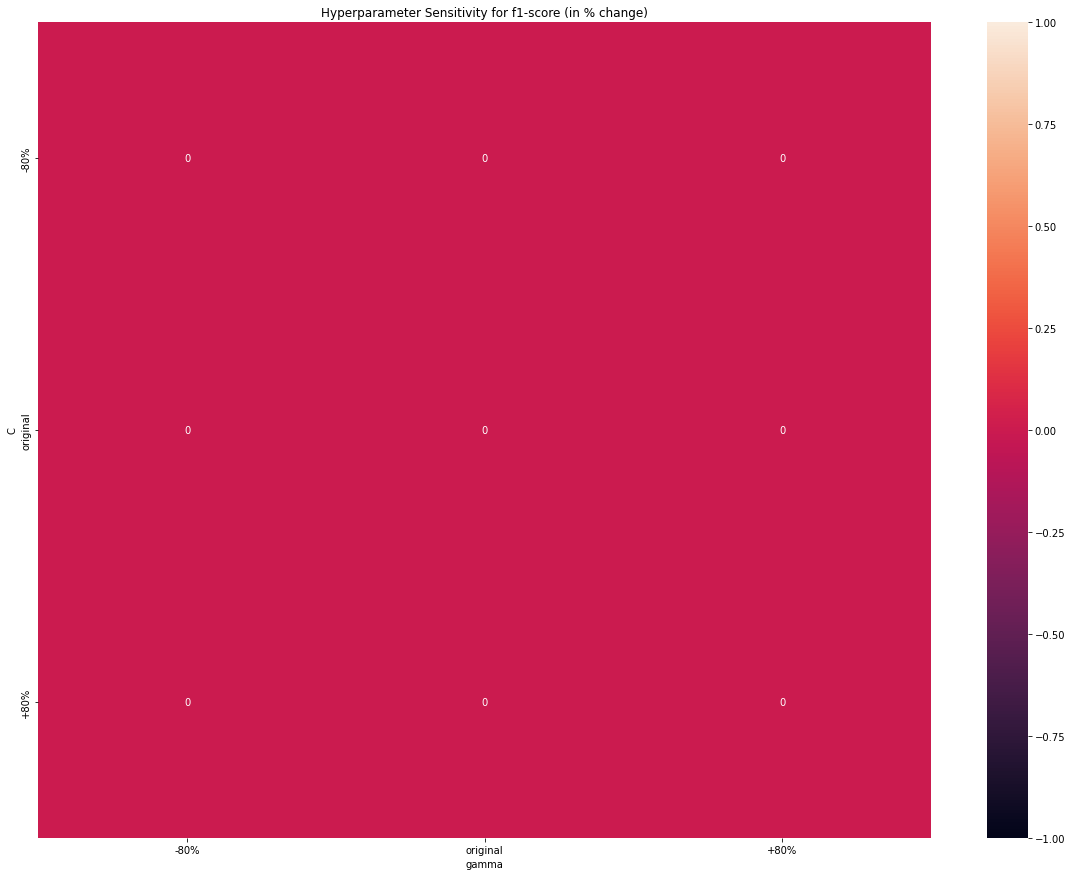

In [ ]:
f1_scores_df = pd.DataFrame(data=(f1_scores/f1_scores[1][1]-1)*100, index=[f'-{CHANGE_PERCENT}%', 'original', f'+{CHANGE_PERCENT}%'], columns=[f'-{CHANGE_PERCENT}%', 'original', f'+{CHANGE_PERCENT}%'])
ax = sns.heatmap(f1_scores_df, vmin=-1, vmax=1, annot=True)
ax.set_xlabel(list(param_grid.keys())[1])
ax.set_ylabel(list(param_grid.keys())[0])
ax.set_title('Hyperparameter Sensitivity for f1-score (in % change)')
plt.show()



In [ ]:
start_time = time.time()
svm_best_model = SVC(random_state = 0, max_iter = 5000, C=0.01, gamma=0.01,verbose=3,kernel='rbf')
svm_best_model.fit(train_X, train_y) 
print("--- %s seconds ---" % (time.time() - start_time))

[LibSVM]--- 37.97314977645874 seconds ---


Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [ ]:
#Fit best model
classification_df = df_14_18.copy()
train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df)

svm_best_model = SVC(random_state = 0,  C=0.01, gamma=0.01,verbose=3,kernel='rbf')
svm_best_model.fit(train_X, train_y)

[LibSVM]

SVC(C=0.01, gamma=0.01, random_state=0, verbose=3)

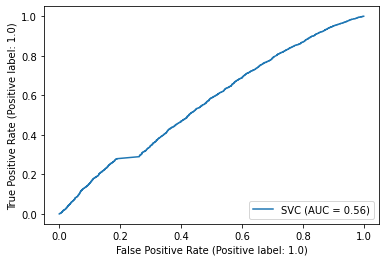

In [ ]:
RocCurveDisplay.from_estimator(svm_best_model, test_X, test_y)

## Feature Importance by model

In this section, we use SHAP to extract feature importance. ** Do not run the code in SVM and MLP section, itcause RAM issues.

#### SVM Feature Importance

The following code is commented, we tried to use Shap.KernelExplainer. However, this crashed the code and returned a RAM issue.

In [ ]:
classification_df = df_14_18.copy()

In [ ]:
# Trying to use this code always resulted in a RAM issue
'''
train_X, train_y, test_X, test_y, (_, test_X_unnorm_df) = prepare_data_for_training(classification_df, return_unnormalized=True)
SAMPLE_NUM = 1
choosen_instance = test_X[SAMPLE_NUM, :]
svm_best_model = SVC(random_state = 0, max_iter = 5000, C=0.01, gamma=0.01,kernel='rbf')
svm_best_model.fit(train_X, train_y)
svm_explainer = shap.KernelExplainer(svm_best_model.predict,test_X)
svm_shap_values = svm_explainer.shap_values(test_X)
shap.summary_plot(svm_shap_values, test_X)
'''

'''
# Create object that can calculate shap values
svm_explainer = shap.KernelExplainer(svm_best_model.predict,test_X)
svm_shap_values = svm_explainer.shap_values(test_X)
'''

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


  0%|          | 0/9352 [00:00<?, ?it/s]

#### Random Forest Feature Importance

In [ ]:
# use this code to search for positive, negative and misclassified samples to plot
positive_sample = False
negative_sample = False
miscls_sample = False

for i, gt in enumerate(test_y):
  pred = rf_cls.predict_proba(test_X[i, :].reshape(1, -1))[0][1]  
  if (int(gt)==1):
    if abs(pred-gt) <= 0.15:
      print(i, pred, gt)
      positive_sample=True
  else:
    if abs(pred-gt) <= 0.2:
      print(i, pred, gt)
      negative_sample=True
  if (int(gt)!=int(pred>=0.5)) and not miscls_sample:
    print(i, pred, gt)
    miscls_sample=True
  if positive_sample and negative_sample and miscls_sample:
    break

In [ ]:
train_X, train_y, test_X, test_y, (_, test_X_unnorm_df) = prepare_data_for_training(classification_df, return_unnormalized=True)
SAMPLE_NUM = 421
rf_explainer = shap.TreeExplainer(rf_cls, data=test_X)
choosen_instance = test_X[SAMPLE_NUM, :]
shap_values = rf_explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(rf_explainer.expected_value[1], shap_values[1], test_X_unnorm_df.loc[[SAMPLE_NUM]], feature_names=feature_names)


100%|===================| 999/1000 [54:52<00:03]       

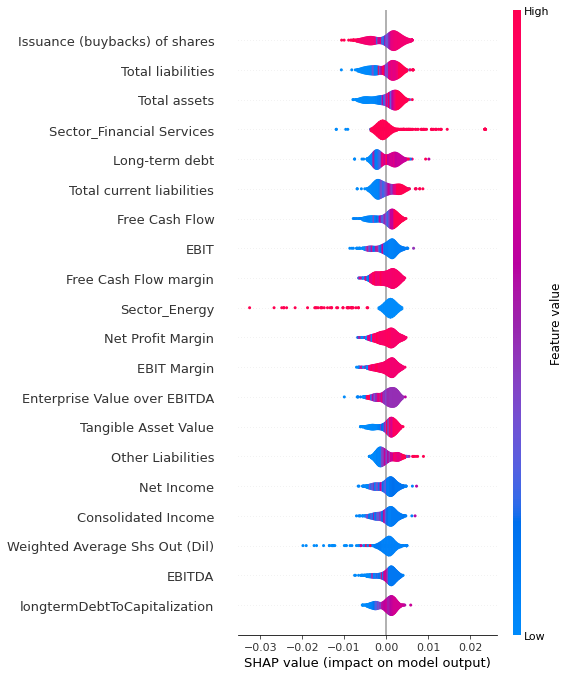

In [ ]:
rf_explainer = shap.TreeExplainer(rf_cls, data=test_X)
sampled_values = shap.sample(test_X, 500)
shap_values = rf_explainer.shap_values(sampled_values)
shap.summary_plot(shap_values[1], sampled_values, feature_names=feature_names,plot_type='violin')

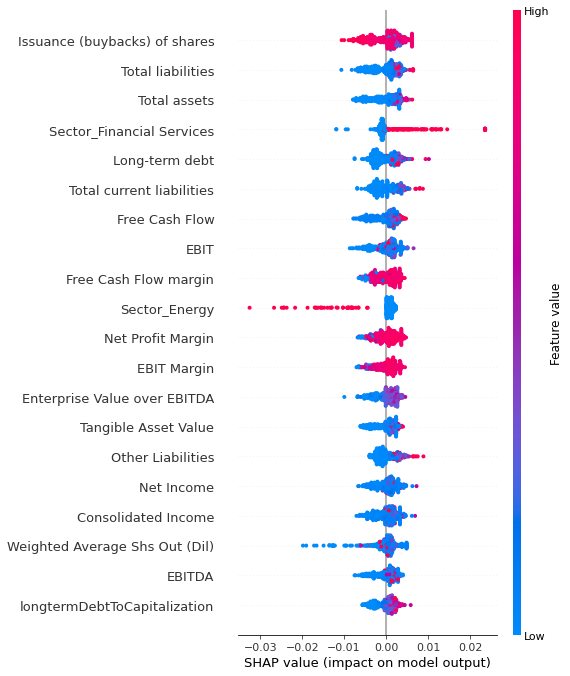

In [ ]:
shap.summary_plot(shap_values[1], sampled_values, feature_names=feature_names)

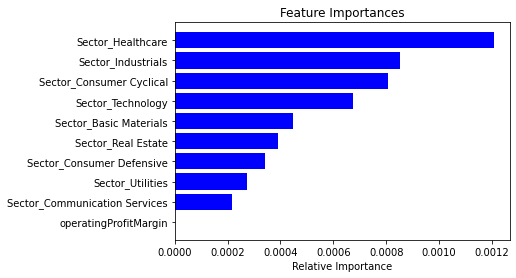

In [ ]:
rf_importances = rf_cls.feature_importances_
indices = np.argsort(rf_importances)[:10]
plt.title('Feature Importances')
plt.barh(range(len(indices)), rf_importances[indices], color='b',
align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


### MLP Feature Importance

The following code is commented, we tried to use Shap.KernelExplainer. However, this crashed the code and returned a RAM issue.

In [ ]:
#function to search for positive, negative and misclassified samples to plot
#inputs: (trained classifier object, test_X, test_y)
#outputs: prints point indicies, pred probs, ground truth

def find_pos_neg_miscl_samples(cls,test_X,test_y):

  positive_sample = False
  negative_sample = False
  miscls_sample = False
  for i, gt in enumerate(test_y):
    pred = cls.predict_proba(test_X[i, :].reshape(1, -1))[0][1]
    # print(pred)
    if (int(gt)==1):
      if abs(pred-gt) <= 0.15:
        print('Positive Sample')
        print(i, pred, gt)
        positive_sample=True
    else:
      if abs(pred-gt) <= 0.2:
        print('Negative Sample')
        print(i, pred, gt)
        negative_sample=True
    if (int(gt)!=int(pred>=0.5)) and not miscls_sample:
      print('Misc Sample')
      print(i, pred, gt)
      miscls_sample=True
    if positive_sample and negative_sample and miscls_sample:
      break

In [ ]:
# This was the code to call the function, but it has a ram Issue

#find_pos_neg_miscl_samples(mlp_classifier,test_X,test_y)

In [ ]:
mlp_explainer = shap.KernelExplainer(mlp_classifier.predict, data=test_X)
sampled_values = shap.sample(test_X, 3)
shap_values = mlp_explainer.shap_values(sampled_values)
shap.summary_plot(shap_values[1], sampled_values, feature_names=feature_names,plot_type='violin')

  0%|          | 0/3 [00:00<?, ?it/s]

# Time Horizon Generalization Study

In this section, we did a time horizon study for our models.

## Predicting Different Horizons of Multiple Years into the Future

The following function calculates how well the models predict a stock if it keeps that stock for multiple years.

In [ ]:
def compare_future_horizons(models, model_names, classification_df):
  assert len(models) == len(model_names)
  test_data_Xs = []
  test_data_ys = []
  train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df.copy(), train_years=[2014, 2015], test_years=[2016], test_multi_year=False)
  test_data_Xs.append(test_X); test_data_ys.append(test_y)
  _, _, test_X, test_y, feature_names = prepare_data_for_training(classification_df.copy(), train_years=[2014, 2015], test_years=[2016, 2017], test_multi_year=True)
  test_data_Xs.append(test_X); test_data_ys.append(test_y)
  _, _, test_X, test_y, feature_names = prepare_data_for_training(classification_df.copy(), train_years=[2014, 2015], test_years=[2016, 2017, 2018], test_multi_year=True)
  test_data_Xs.append(test_X); test_data_ys.append(test_y)

  f1_dict, precision_dict = {}, {}
  for i, model in enumerate(models):
    model.fit(train_X, train_y)
    f1_dict[model_names[i]] = []
    precision_dict[model_names[i]] = []
    for j, _ in enumerate(test_data_Xs):
      data=test_data_Xs[j]
      labels=test_data_ys[j]
      preds = model.predict(data)
      tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
      f1_dict[model_names[i]].append((2*tp)/(2*tp+fp+fn))

      
      precision_dict[model_names[i]].append(precision_score(labels, preds))
  info = [["1 Year", "2 Years", "3 Years"]]
  for model_name in model_names:
    info.extend([f1_dict[model_name], precision_dict[model_name]])
  info_t = pd.DataFrame(info).T.values.tolist()
  headers = []; [headers.extend([f"{m} F1-Score", f"{m} Precision"]) for m in model_names]
  print(tabulate(info_t, headers=headers))

In [ ]:
classification_df = df_14_18.copy()

rf_best_model_horizons1 = RandomForestClassifier(random_state=0, n_estimators=2500, max_features=4)
mlp_best_model_horizons1 = MLPClassifier(random_state=0,activation= 'logistic', batch_size = 200, hidden_layer_sizes = 200, learning_rate = 'constant')
svm_best_model_horizons1 = SVC(random_state=0, max_iter=5000, C=0.01, gamma=0.01, kernel='rbf')

compare_future_horizons([rf_best_model_horizons1, mlp_best_model_horizons1, svm_best_model_horizons1], ["RF", "MLP", "SVM"], classification_df)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


           RF F1-Score    RF Precision    MLP F1-Score    MLP Precision    SVM F1-Score    SVM Precision
-------  -------------  --------------  --------------  ---------------  --------------  ---------------
1 Year        0.693732        0.694488        0.720512         0.724474        0.802994         0.670836
2 Years       0.693947        0.694488        0.720738         0.724474        0.802696         0.670419
3 Years       0.584361        0.49455         0.579619         0.492303        0.633528         0.463623


## Training on Different Time Horizons

In this section, we analyze how the model react if instead of training our models on our baseline dataset, we train the model on different years (2016), (2016,2017), (2016-2018)

In [ ]:
def compare_training_horizons(models, model_names, classification_df):
  assert len(models) == len(model_names)
  train_data_Xs = []
  train_data_ys = []
  test_data_Xs = []
  test_data_ys = []
  train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df.copy(), train_years=[2016], test_years=[2017, 2018], test_multi_year=False)
  train_data_Xs.append(train_X); train_data_ys.append(train_y);   test_data_Xs.append(test_X); test_data_ys.append(test_y)
  train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df.copy(), train_years=[2015, 2016], test_years=[2017, 2018], test_multi_year=False)
  train_data_Xs.append(train_X); train_data_ys.append(train_y);   test_data_Xs.append(test_X); test_data_ys.append(test_y)
  train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df.copy(), train_years=[2014, 2015, 2016], test_years=[2017, 2018], test_multi_year=False)
  train_data_Xs.append(train_X); train_data_ys.append(train_y);   test_data_Xs.append(test_X); test_data_ys.append(test_y)
  f1_dict, precision_dict = {}, {}
  for i, model in enumerate(models):
    f1_dict[model_names[i]] = []
    precision_dict[model_names[i]] = []
    for j, _ in enumerate(train_data_Xs):
      model.fit(train_data_Xs[j], train_data_ys[j])
      preds = model.predict(test_data_Xs[j])
      tn, fp, fn, tp = confusion_matrix(test_data_ys[j], preds).ravel()
      f1_dict[model_names[i]].append((2*tp)/(2*tp+fp+fn))
      precision_dict[model_names[i]].append(precision_score(test_data_ys[j], preds))
  info = [["1 Year", "2 Years", "3 Years"]]
  for model_name in model_names:
    info.extend([f1_dict[model_name], precision_dict[model_name]])
  info_t = pd.DataFrame(info).T.values.tolist()
  headers = []; [headers.extend([f"{m} F1-Score", f"{m} Precision"]) for m in model_names]
  print(tabulate(info_t, headers=headers))

In [ ]:
classification_df = df_14_18.copy()

rf_best_model_horizons2 = RandomForestClassifier(random_state=0, n_estimators=2500, max_features=4)
mlp_best_model_horizons2 = MLPClassifier(random_state=0,activation= 'logistic', batch_size = 200, hidden_layer_sizes = 200, learning_rate = 'constant')
svm_best_model_horizons2 = SVC(random_state=0, max_iter=5000, C=0.01, gamma=0.01, kernel='rbf')

compare_training_horizons([rf_best_model_horizons2, mlp_best_model_horizons2, svm_best_model_horizons2], ["RF", "MLP", "SVM"], classification_df)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


           RF F1-Score    RF Precision    MLP F1-Score    MLP Precision    SVM F1-Score    SVM Precision
-------  -------------  --------------  --------------  ---------------  --------------  ---------------
1 Year        0.643909        0.500881        0.624365         0.493744        0.641488         0.472198
2 Years       0.645223        0.498886        0.631468         0.492763        0.641488         0.472198
3 Years       0.643262        0.513437        0.615509         0.509423        0.641488         0.472198


## PCA Study

In this section, we look at the effect of using PCA on our baseline model.

In [ ]:
rf_pca_model = RandomForestClassifier(random_state=0, n_estimators=2500, max_features=4)
mlp_pca_model = MLPClassifier(random_state=0,activation= 'logistic', batch_size = 200, hidden_layer_sizes = 200, learning_rate = 'constant')
svm_pca_model = SVC(random_state=0, max_iter=5000, C=0.01, gamma=0.01, kernel='rbf')
models = [rf_pca_model,mlp_pca_model,svm_pca_model]
classification_df = df_14_18.copy()
train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(classification_df, train_years=[2014,2015,2016], test_years=[2017, 2018], apply_pca=True)
for model in models:
  model.fit(train_X, train_y)
compare_metrics(models, test_X, test_y, ["RF", "MLP", "SVM"])

(12725, 105)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Model      Accuracy    F1-Score    Precision         NPV    Recall    Specificity
-------  ----------  ----------  -----------  ----------  --------  -------------
RF         0.523631    0.62946      0.497437    0.637822  0.856884       0.225486
MLP        0.529512    0.616457     0.501134    0.616725  0.800725       0.286872
SVM        0.472198    0.641488     0.472198  nan         1              0


invalid value encountered in long_scalars


## Feature Reduction Study

In this section, we look at the effect of the Feature Reduction we did.

In [ ]:
rf_pca_model = RandomForestClassifier(random_state=0, n_estimators=2500, max_features=4)
mlp_pca_model = MLPClassifier(random_state=0,activation= 'logistic', batch_size = 200, hidden_layer_sizes = 200, learning_rate = 'constant')
svm_pca_model = SVC(random_state=0, max_iter=5000, C=0.01, gamma=0.01, kernel='rbf')
models = [rf_pca_model,mlp_pca_model,svm_pca_model]
train_X, train_y, test_X, test_y, feature_names = prepare_data_for_training(df_14_18_reduced.copy(), train_years=[2014,2015,2016], test_years=[2017, 2018])
for model in models:
  model.fit(train_X, train_y)
compare_metrics(models, test_X, test_y, ["RF", "MLP", "SVM"])

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Model      Accuracy    F1-Score    Precision         NPV    Recall    Specificity
-------  ----------  ----------  -----------  ----------  --------  -------------
RF         0.547156    0.641679     0.512225    0.679836  0.858696       0.268436
MLP        0.538601    0.614422     0.507454    0.620489  0.778533       0.323947
SVM        0.472198    0.641488     0.472198  nan         1              0


invalid value encountered in long_scalars
